# TP analyse et traitement du son

DA SILVA PEREIRA Théo

In [117]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
TPson
Created on October 2024
@author: gouiffes
"""
#import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import wave
from scipy.io import wavfile

### Fonction : Création du signal synthétique


In [118]:
"""
Composed signal of duration 1s
n : nb samples
"""
def synthetic_signal(n):
    # Signal composé périodique artificiel 
    tmax=1            # durée du signal 
    T=0.1               # période du signal en secondes 
    omega=2*np.pi/T     # pulsation. ω = rapport du "tour complet" (2*pi) par la 
                    # durée nécessaire pour le parcourir = "vitesse angulaire" (rad/s)
    phi=np.pi/2         # phase à l'origine (rad)
    Smax=5              # amplitude du signal

    
    Te= tmax/n          # periode d'échantillonnage (durée entre 2 échantillons)
    Fe=1/Te             # fréquence d'échantillonnage

    t=[k*Te for k in range(n+1)]    #axe temporel

    # Le signal s est composé de 3 sinusoïdes
    s1=[Smax*np.sin(omega*t+phi) for t in t] 
    s2=[Smax/2.*np.sin(8*omega*t+phi) for t in t]
    s3=[Smax/4.*np.sin(12*omega*t+phi) for t in t]
    s=np.add(np.add(s1, s2), s3)
    plt.figure()
    plt.suptitle('Signal composé', fontsize=16)
    plt.subplot(411), plt.ylabel("Signal s1(t)"), plt.plot(t, s1, 'r')
    plt.subplot(412), plt.ylabel("Signal s2(t)"), plt.plot(t, s2, 'g')
    plt.subplot(413), plt.xlabel("Temps t (s)"), plt.ylabel("Signal s3(t)"), plt.plot(t, s3, 'b')
    plt.subplot(414), plt.xlabel("Temps t (s)"), plt.ylabel("Signal s(t)"), plt.plot(t, s, 'k')
    plt.show(block=False)
    return s, t, Fe

### Fonction :  Transformée de Fourier  (Fast Fourier Transform)
Compléter la fonction :
- créer un vecteur f allant de -Fe/2 à Fe/2
- calculer la FFT
- décaler le spectre pour qu'il soit centré sur 0



In [119]:
def my_fft(s, Fe):
    # Computes FFT of the signal/sound s and prepares the f axis 
    n=len(s)
    f=[]
    S = []

    f = np.linspace(-Fe/2, Fe/2, n)

    S = np.fft.fft(s)
    S = np.fft.fftshift(S)
    return f, S

### Fonction d'affichage

In [120]:
def display(t, s, f, S, text):
    #Display the temporal and frequential représentations in a figure with title text
    plt.figure()
    plt.suptitle(text, fontsize=16)
    plt.subplot(211)
    plt.ylabel("Signal s(t)")
    plt.plot(t, s)
    plt.subplot(212)
    plt.ylabel("Spectre ")
    plt.xlabel("Fréquence (Hz)")
    plt.plot(f, S)
    plt.show(block=False)

# I. Signaux synthétiques 
## I.I. Spectre du signal

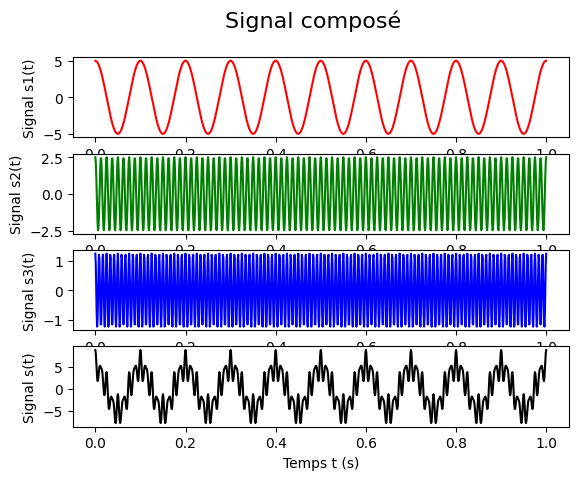

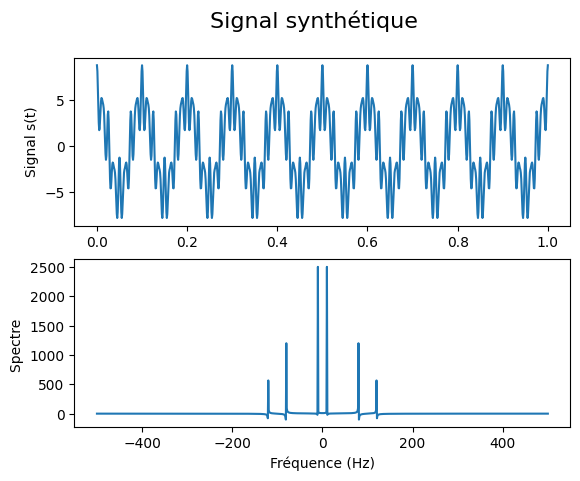

In [121]:
n=1000 # nb samples
s, t, Fe= synthetic_signal(n)
f, S= my_fft(s, Fe)
display(t, s, f, S, 'Signal synthétique')


**Vos réponses** : 

Pour n=1000 :
- Fréquence fondamentale  : 10Hz
- Harmoniques : 80Hz et 120Hz
- Fréquence maximale Fmax : 120Hz
- Fréquence d'échantillonnage minimale : 10Hz 
- Période d'échantillonnage : 0.1s
- Commentaires : Le nombre d'échantillon minimum est 10.

---

Commentaires pour n=240 :
- L'harmonique à 120Hz a disparu
- L'amplitude a diminué

---

Commentaires pour n=200 :
- L'amplitude a encore diminué




## 1.2 Transformations  
### Low pass filtering 

In [122]:
def lowpass_filter(cutoff, fs, order=5):
    #Define low pass filter (Butterworth)
    fs2 = 0.5 * fs
    normal_cutoff = cutoff / fs2
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff, fs, order=5):
    # Apply low pass filter (Butterworth) on the signal data
    b, a = lowpass_filter(cutoff, fs, order)
    y = lfilter(b, a, data)
    return y

### Effects : reverbe and distortion

In [123]:
"""
Reverbe effect
    alpha : magnitude of the echo
    delta : temporal delay
Returns the modified signal
"""
def reverb(audio_data, delta, alpha):
    reverb_data = []
    for t in range(len(audio_data)):
        reverb_data.append((1 - alpha)*audio_data[t] + alpha*audio_data[t - delta])
    return reverb_data[:len(audio_data)] #.tobytes()

"""
Distortion effect
    audio_data : sound
    threshold : value of the threshold
Returns the modified signal
"""
def distortion(audio_data, threshold):
    distort_data=audio_data
    for t in range(len(audio_data)):
        if audio_data[t] > threshold:
            distort_data[t] = threshold
        else:
            if audio_data[t] < -threshold:
                distort_data[t] = -threshold
    return distort_data


### Application du filtrage passe-bas

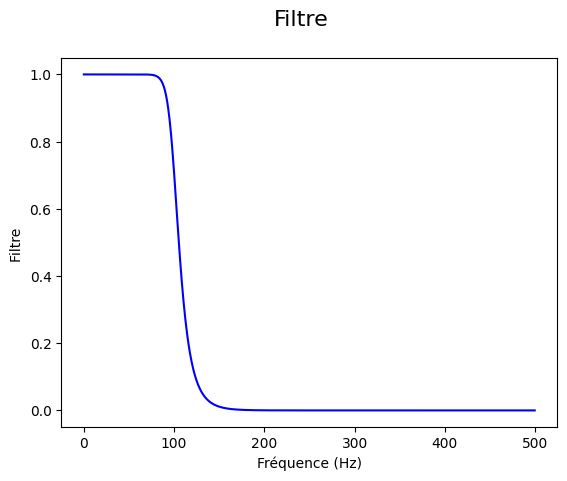

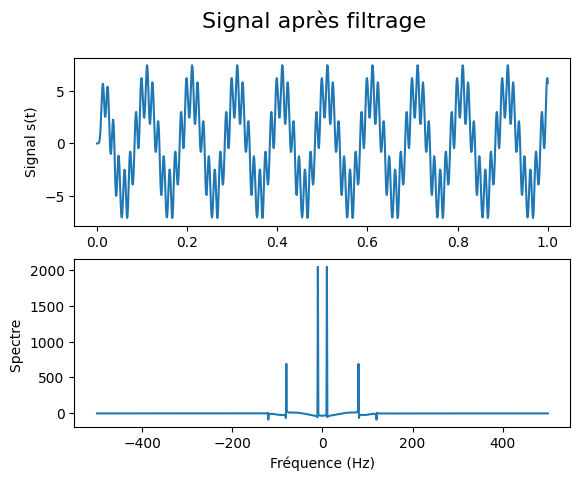

In [124]:
order = 10  # a modifier 
cutoff = 100 # a modifier 
b, a = lowpass_filter(cutoff, Fe, order)

# Réponse fréquentielle du filtre
w, h = freqz(b, a, worN=n)

plt.figure()
plt.suptitle('Filtre', fontsize=16)
plt.ylabel("Filtre ")
plt.xlabel("Fréquence (Hz)")
plt.plot(0.5 * Fe * w / np.pi, np.abs(h), "b")
plt.show(block=False)

# a decommenter
sf = apply_lowpass_filter(s, cutoff, Fe, order)

f, Sf= my_fft(sf, Fe)

display(t, sf, f, Sf, 'Signal après filtrage')


### Application des effets

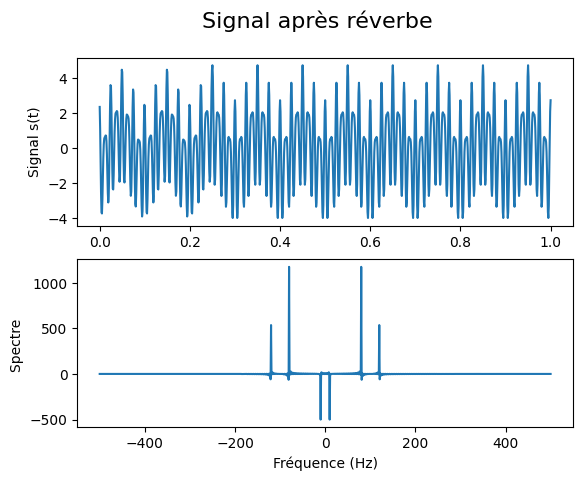

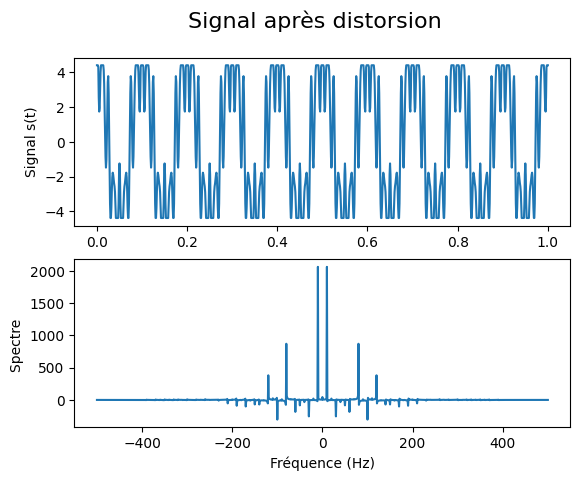

In [125]:
n_delay=int(n/4)
sr=reverb(s, n_delay, 0.6 )
f, Srf= my_fft(sr, Fe)
display(t, sr, f, Srf, 'Signal après réverbe' )
threshold=0.5*s.max()
sd=distortion(s, threshold)
f, Sdf= my_fft(sd, Fe)
display(t, sd, f, Sdf, 'Signal après distorsion')
plt.pause(0)

# 2. Sons réels

In [ ]:
"""
Reads a .wav file and displays the sound in time and frequency domains
Returns :
    s : the temporal sound
    S : the spectrum
    f : frequency axis
    Fe : Sampling frequency

"""
def read_show_wave(son, text):
    f = wave.open(son, 'rb')
    # read the fila
    Fe, s1 = wavfile.read(son)
    nch = f.getnchannels()
    if nch==1:
        s = s1
    else:
        s=s1[:,0w]
    # number of samples
    n=np.size(s)
    # sample period 
    Te=1/Fe
    # signal duration 
    D=n*Te
    t=[k*Te for k in range(n)]    #axe temporel
    f, S= my_fft(s, Fe)
    display(t, s, f, S, text)
    return s, S, f, Fe

## 2.1 et 2.2 Fréquence d'échantillonnage et comparaison des spectres

/tmp/ipykernel_5629/3952563094.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fe, s1 = wavfile.read(son)


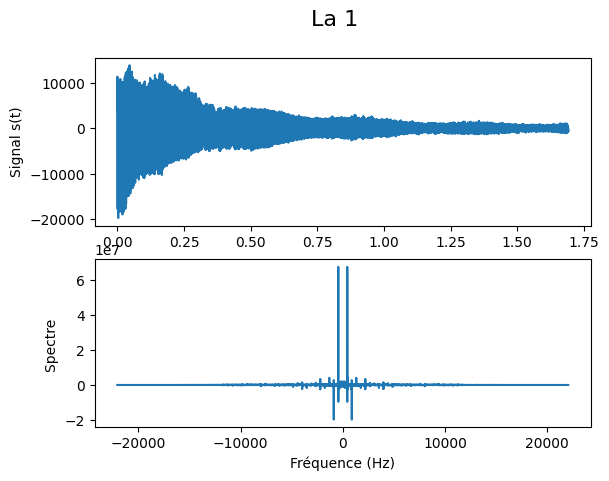

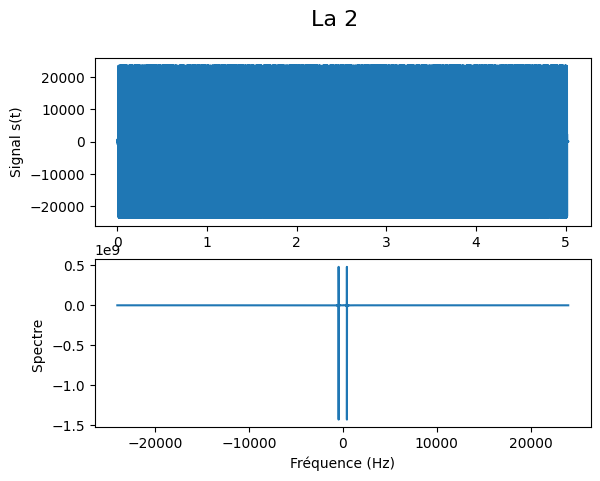

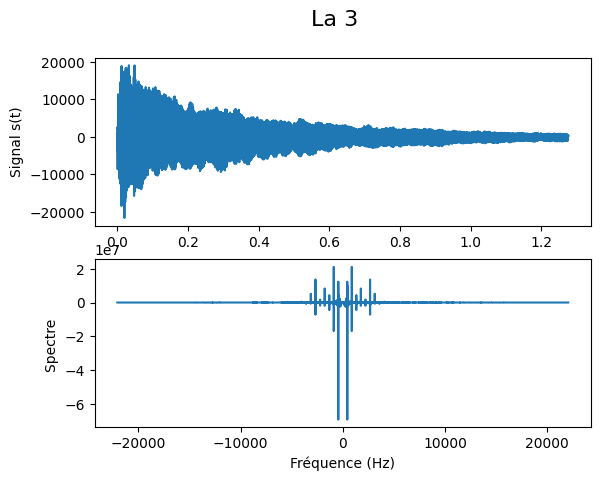

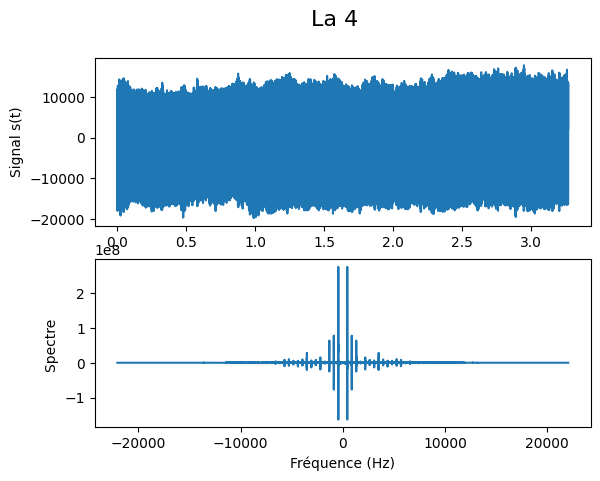

In [128]:
# Sons simples : differents LA

LA1="LA3_GUITAR.wav"
LA2="LA3_DIAPASON.wav"
LA3="LA3_PIANO.wav"
LA4="LA3_SAXO.wav"

# Affichage 
la1, S, f, Fe= read_show_wave(LA1, "La 1")
la2, S, f, Fe= read_show_wave(LA2, "La 2")
la3, S, f, Fe= read_show_wave(LA3, "La 3")
la4, S, f, Fe= read_show_wave(LA4, "La 4")


# 2.3 Sons réels : filtrage passe-bas

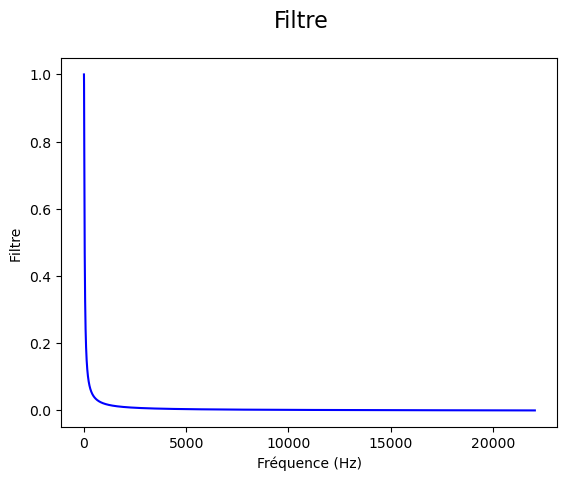

TypeError: cannot unpack non-iterable int object

In [ ]:
# Filtering 
order = 1 # a modifer
cutoff = 20 # a modifer
n=len(la1)
b, a = lowpass_filter(cutoff, Fe, order)
# Réponse fréquentielle du filtre
w, h = freqz(b, a, worN=n)
plt.figure()
plt.suptitle('Filtre', fontsize=16)
plt.ylabel("Filtre ")
plt.xlabel("Fréquence (Hz)")
plt.plot(0.5 * Fe * w / np.pi, np.abs(h), "b")
plt.show(block=False)

sf = apply_lowpass_filter(la1, cutoff, Fe, order)
f, Sf=my_fft(sf, Fe)
plt.plot(f, Sf)
wavfile.write('la1_filtre.wav', Fe, sf)
   


# 2.4 Sons réels : Effets

Playing MUSIC1.wav


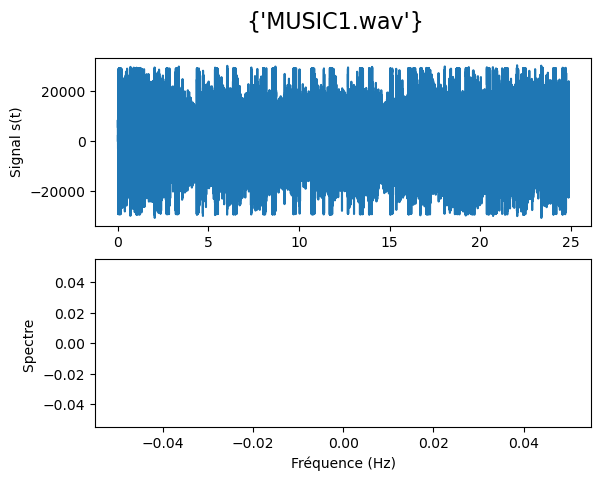

In [ ]:
S1="MUSIC1.wav"

wav_file=S1
print(f"Playing {wav_file}")
s, S, f, Fe= read_show_wave(wav_file, {wav_file})

# Reverbe effect
sr=reverb(s, 20, 0.3)
wavfile.write('S_reverb.wav', Fe, sr)
    
# Distortion
sd=distortion(s, 0.9*np.max(s))
wavfile.write('S_distorsion.wav', Fe, sd)


# 2.5. Sons réels : représentation temps-fréquence

In [ ]:

""" Time-frequency Representation 
D :  analysis interval time 
"""
def time_frequency(son, D):
    f = wave.open(son, 'rb')
    # read the file
    Fe, s1 = wavfile.read(son)

    nch = f.getnchannels()
    if nch==1:
        s = s1
    else:
        s=s1[:,0]

    # number of samples
    n=np.size(s)
    # sample period (time between two samples)
    Te=1/Fe
    # number of samples in one analysis window
    M=int(D/Te)
    # max number of intervals 
    N= int(n/M)

    print(M, "rows ", N, " cols")
   
    S=np.array(np.zeros((M,N))) #, dtype=np.float)
    # completer 
    # ...
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    cax = ax.matshow(S,  aspect='auto')
    fig.colorbar(cax)

    yaxis = np.arange(N+1)
    ax.set_yticklabels(yaxis) 
    plt.show()
    return 1


441 rows  2487  cols


/tmp/ipykernel_91253/853230102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yaxis)


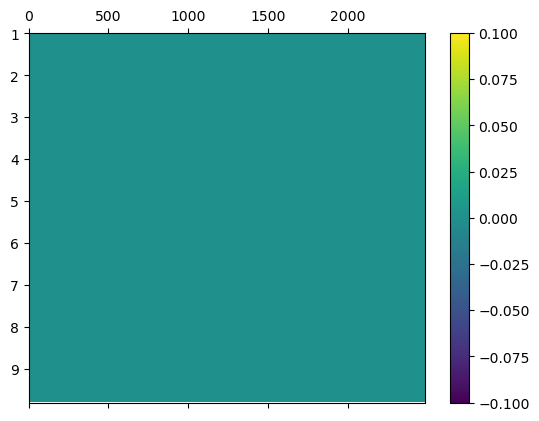

1

In [ ]:
# Time-frequency Representation 
time_frequency(wav_file, 0.01)


Vos commentaires ici

# 2.6 Sons réels : comparaison entre signaux

In [ ]:

"""
Compare two signal using their Fourier transform
"""
def compare_spectres(s0, s1):
    # completer 
    # ...
    vmin=0      
    return(vmin)  


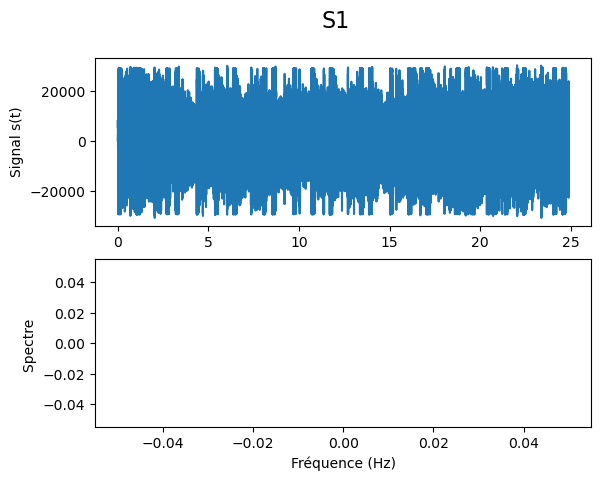

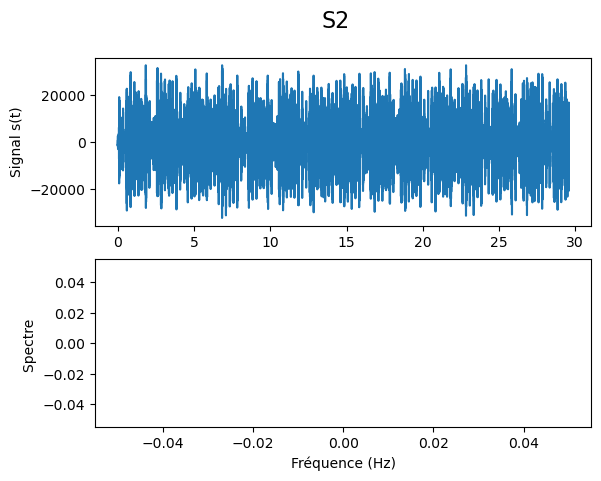

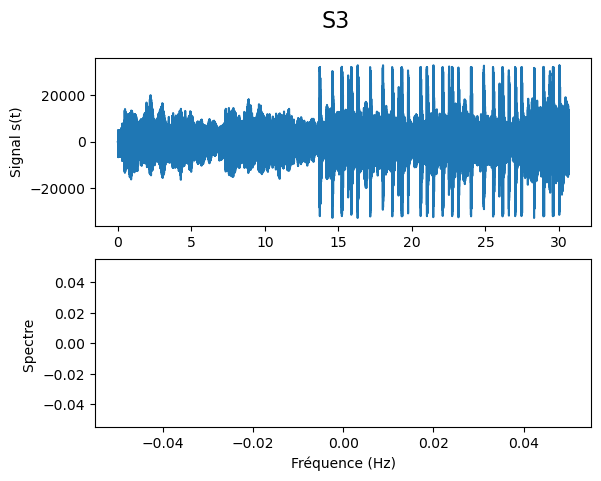

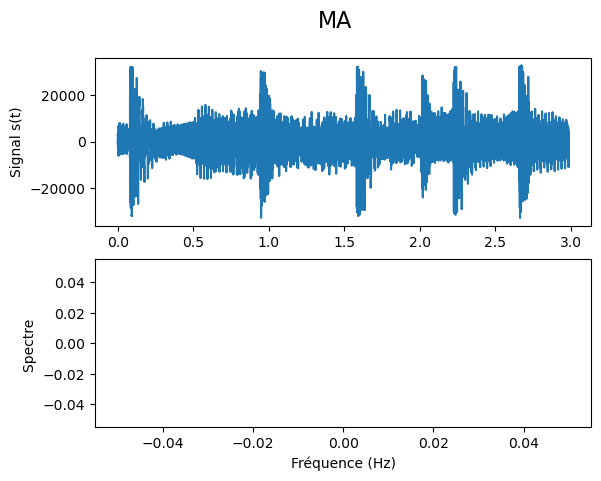

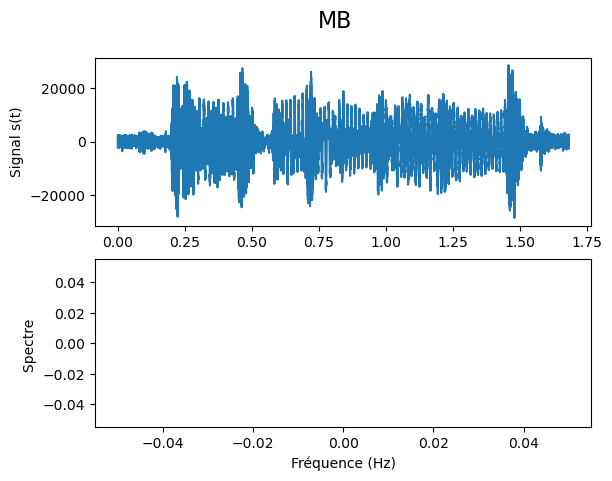

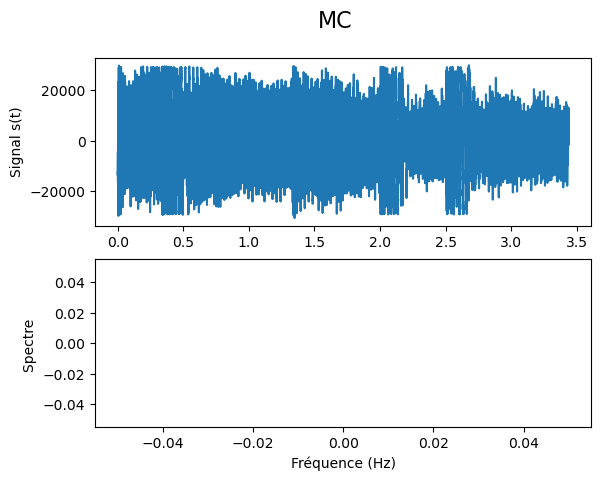

le signal le plus ressemblant à A:  0
le signal le plus ressemblant à B:  0
le signal le plus ressemblant à C:  0


In [ ]:
MA="MUSIC_A.wav"
MB="MUSIC_B.wav"
MC="MUSIC_C.wav"

S1="MUSIC1.wav"
S2="MUSIC2.wav"
S3="MUSIC3.wav"

# Signal comparison
s1, S, f, Fe= read_show_wave(S1, "S1")
s2, S, f, Fe= read_show_wave(S2, "S2")
s3, S, f, Fe= read_show_wave(S3, "S3")
    
sA, S, f, Fe= read_show_wave(MA, "MA")
sB, S, f, Fe= read_show_wave(MB, "MB")
sC, S, f, Fe= read_show_wave(MC, "MC")
    
d=[]
    
d.append(compare_spectres(sA, s1))
d.append(compare_spectres(sA, s2))
d.append(compare_spectres(sA, s3))
np.min(d)
print("le signal le plus ressemblant à A: ", np.argmin(d))

d=[]
d.append(compare_spectres(sB, s1))
d.append(compare_spectres(sB, s2))
d.append(compare_spectres(sB, s3))
np.min(d)
print("le signal le plus ressemblant à B: ", np.argmin(d))   

d=[]
d.append(compare_spectres(sC, s1))
d.append(compare_spectres(sC, s2))
d.append(compare_spectres(sC, s3))
np.min(d)
print("le signal le plus ressemblant à C: ", np.argmin(d)) 
 

plt.pause(0)

Vos commentaires ici